# Práctico 02: Anáslisis Exploratorio y Curación - Resolución

## Importar librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Opción para ver todas las columnas del dataset en el notebook
pd.set_option('display.max_columns', 50)

In [ ]:
df = pd.read_csv('data.csv', sep = ";")
df.head(3)

## Análisis de las variables

### Valores nulos

In [ ]:
df.isna().sum()

Si bien el dataset es prolijo en no tener datos faltantes cabe señalar que si indica datos "desconocidos":
- Job: 330 "unknown"
- Marital: 80 "unknown"
- Education: 1731 "desconocido"
- Default: 8597 "unknown"
- Housing & loan: 990 "unknown" (coinciden las observaciones para ambas variables)

#### Valores unknown

In [ ]:
fig, axs = plt.subplots(nrows=3,ncols=2, figsize=(30,30))

sns.countplot(data=df, x='job', ax=axs[0,0])
sns.countplot(data=df, x='marital', ax=axs[0,1])
sns.countplot(data=df, x='education', ax=axs[1,0])
sns.countplot(data=df, x='default', ax=axs[1,1])
sns.countplot(data=df, x='housing', ax=axs[2,0])
sns.countplot(data=df, x='loan', ax=axs[2,1])

### Outliers

In [ ]:
fig, axs = plt.subplots(nrows=5,ncols=2, figsize=(30,30))

sns.boxplot(data=df, x='duration', ax=axs[0,0])
sns.boxplot(data=df, x='duration', showfliers=False, ax=axs[0,1]).set(xlabel='Duartion sin outliers')

sns.boxplot(data=df, x='age', ax=axs[1,0])
sns.boxplot(data=df, x='age', showfliers=False, ax=axs[1,1]).set(xlabel='Edad sin outliers')

sns.boxplot(data=df, x='campaign', ax=axs[2,0])
sns.boxplot(data=df, x='campaign', showfliers=False, ax=axs[2,1]).set(xlabel='Campaign sin outliers')

sns.boxplot(data=df, x='previous', ax=axs[3,0])
sns.boxplot(data=df, x='previous', showfliers=False, ax=axs[3,1]).set(xlabel='Previous sin outliers')

sns.boxplot(data=df, x='cons.conf.idx', ax=axs[4,0])
sns.boxplot(data=df, x='cons.conf.idx', showfliers=False, ax=axs[4,1]).set(xlabel='cons.conf.idx sin outliers')

### Distribuciones de las variables numéricas

In [ ]:
fig, axs = plt.subplots(nrows=5,ncols=2, figsize=(30,30))

sns.histplot(data=df, x='age', kde=True, ax=axs[0,0])
sns.histplot(data=df, x='duration', kde=True, ax=axs[0,1])
sns.histplot(data=df, x='campaign', kde=True, ax=axs[1,0])
sns.histplot(data=df, x='pdays', kde=True, ax=axs[1,1])
sns.histplot(data=df, x='previous', kde=True, ax=axs[2,0])
sns.histplot(data=df, x='emp.var.rate', kde=True, ax=axs[2,1])
sns.histplot(data=df, x='cons.price.idx', kde=True, ax=axs[3,0])
sns.histplot(data=df, x='cons.conf.idx', kde=True, ax=axs[3,1])
sns.histplot(data=df, x='euribor3m', kde=True, ax=axs[4,0])
sns.histplot(data=df, x='nr.employed', kde=True, ax=axs[4,1])


### Cardinalidad de las variables categóricas

In [ ]:
fig, axs = plt.subplots(nrows=5,ncols=2, figsize=(30,30))

sns.countplot(data=df, x='job', ax=axs[0,0])
sns.countplot(data=df, x='marital', ax=axs[0,1])
sns.countplot(data=df, x='education', ax=axs[1,0])
sns.countplot(data=df, x='default', ax=axs[1,1])
sns.countplot(data=df, x='housing', ax=axs[2,0])
sns.countplot(data=df, x='loan', ax=axs[2,1])
sns.countplot(data=df, x='contact', ax=axs[3,0])
sns.countplot(data=df, x='month', ax=axs[3,1])
sns.countplot(data=df, x='day_of_week', ax=axs[4,0])
sns.countplot(data=df, x='poutcome', ax=axs[4,1])


### Correlación entre las variables

In [ ]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Tratamiento y modificación de las variables

### Outliers

In [10]:
from scipy.stats import zscore

# Elimacion de unicamente los outliers - df
def delete_outliers(df, cols):
    df = df.copy()
    temp = []
    df_clean = df.copy()

    for c in cols:
        z_scores = zscore(df_clean[c])
        abs_z_scores = np.abs(z_scores)
        filtered_entries = (abs_z_scores < 3)
        row_clean = df_clean[filtered_entries][c]
        temp.append([c, len(df_clean[c]), len(row_clean), len(df_clean[c]) - len(row_clean), df_clean[c].isna().sum() ])
        df_clean = df_clean[filtered_entries]
    temp = pd.DataFrame(temp, columns=["name", "count_values", "without_outliers", "count_outliers", "nan_count"])

    df_with_nan = df[cols][df[cols].isna().any(axis=1)]

    df_clean.merge(df_with_nan)

    return temp, df_clean

# columnas a analizar y eliminar outliers
temp, df = delete_outliers(df, ['duration', 'age', 'cons.conf.idx'] )

In [11]:
temp

,name,count_values,without_outliers,count_outliers,nan_count
0,duration,41188,40327,861,0
1,age,40327,39963,364,0
2,cons.conf.idx,39963,39963,0,0


### Distribuciones de las variables numéricas

#### Creación de la variable contactado
La variable "contactado", determina si el usuario fue previamente contactado o no. Esta conclusión se realizó, porque en la información de atributos dice que los usuarios con pdays = 999, no fueron contactados previamente.

<AxesSubplot:xlabel='contactado', ylabel='count'>

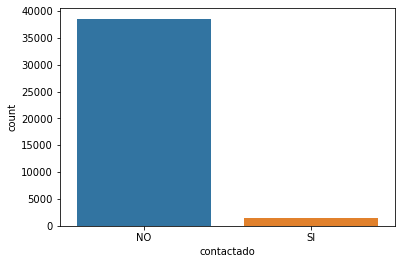

In [12]:
def get_contactado(x):
    if x >= 999:
        return '0'
    elif x < 6:
        return '1'
    elif 5 < x < 11:
        return '2'   
    else:
        return '3'

df['contactado'] = df.apply(lambda x: get_contactado(x['pdays']), axis=1)
    
# Drop de columna pdays
df.drop('pdays', axis=1, inplace=True)

sns.countplot(data=df, x='contactado')

### Codificación del target

<AxesSubplot:xlabel='y', ylabel='count'>

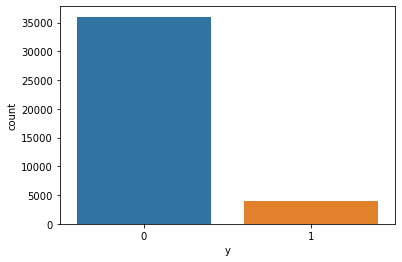

In [13]:
# Transformo la variable target para calcular P-Value
def factorize_y(x):
    if x == 'no':
        return 0
    else:
        return 1
    
df['y'] = df.apply(lambda x: factorize_y(x['y']), axis=1)

sns.countplot(data=df, x='y')

### Cardinalidad de las variables categóricas

#### Educacion

<AxesSubplot:xlabel='education', ylabel='count'>

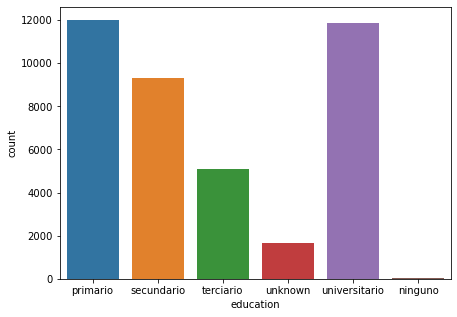

In [14]:
df.education.replace({'unknown': 'unknown',
            'illiterate': 'ninguno',
            'basic.4y': 'primario',
           'basic.6y':'primario',
           'basic.9y': 'primario',
           'high.school':'secundario',
           'professional.course':'terciario',
           'university.degree':'universitario'}, inplace=True)

fig, axs = plt.subplots(figsize=(7,5))
sns.countplot(data=df, x='education')

#### Productos financieros

<AxesSubplot:xlabel='productos_financieros', ylabel='count'>

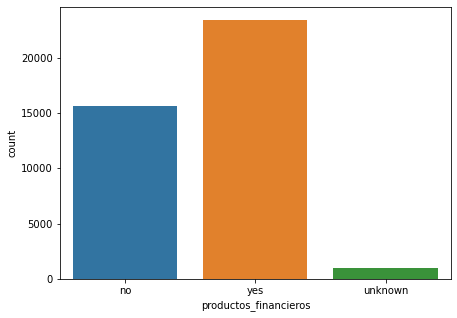

In [15]:
def productos_financieros(x):
    if x.loan == 'yes' or x.housing == 'yes':
        return 'yes'
    elif x.loan == 'unknown' or x.housing == 'unknown':
        return 'unknown'
    else:
        return 'no'
    
# Creamos esta columna para ver si el usuario adquirio productos financieros
df['productos_financieros'] = df.apply(lambda x: productos_financieros(x), axis=1)

# Drop de columnas loan y housing
df.drop(['loan', 'housing'], axis=1, inplace=True)

fig, axs = plt.subplots(figsize=(7,5))
sns.countplot(data=df, x='productos_financieros')

#### Dummeo de variables categoricas
Se dummean las variables categoricas para poder utilizar el modelo XGBoost, ya que, solamente acepta variables numericas.

In [16]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_primario,education_secundario,education_terciario,education_universitario,education_unknown,default_unknown,default_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,contactado_SI,productos_financieros_unknown,productos_financieros_yes
0,56,261,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
1,57,149,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
2,37,226,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
3,40,151,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
4,56,307,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1


### Correlacion entre variables

Drop de las variables "emp.var.rate", "cons.price.idx", "cons.conf.idx", "nr.employed". Esto se realiza porque nos quedamos solamente con la variable macroeconómica "euribor3m", ya que, es la variable del grupo más influyente en la decisión de venta del activo financiero en cuestión.

In [17]:
df.drop(["emp.var.rate", "cons.price.idx", "cons.conf.idx", "nr.employed"], axis=1, inplace=True)

### Guardar el dataset final

In [18]:
df.to_parquet('data_preprocessed.parquet', index=False)